# 混合正規モデル(Gaussian Mixture Model; GMM)の教師なし学習

$K$個の正規分布の混合分布から$N$個のデータ(今回は1次元データ)を測定する．

ここでは，このような状況において，観測データからもとの$K$個の各正規分布のパラメータ，および各分布の混合の割合を最尤推定する問題を扱う．

GMMでは，対数尤度関数の微分 $=0$を解析的に解くのは困難なので，**EMアルゴリズム**に基づいた教師なし学習が用いられる．今回はそのアルゴリズムを実装する．

## アルゴリズム

1. 所属確率 $p(k|x_i) (i=1,..,N , k = 1,..,K)$ の初期値を与える．
    - この確率はデータ$x_i$が与えられたときに，それがクラス$k$（つまり，$k$番目の正規分布から発生したデータであるということ）である条件付き確率を表す．
    - 初期化の際には，$\sum_k^K p(k|x_i) = 1 (i=1,..,N)$ となるように正規化してやる必要があるので注意．


2. 各クラス$k$に所属するデータの数の推定値$N_k$を以下で計算する．
$$
    N_k = \sum_i^N p(k|x_i)　(k=1,..,K)
$$


3. 各クラス$k$の正規分布のパラメータ$\mu_k$と$\sigma^2_k$の推定値を以下で計算する．
$$
    \mu_k = \frac{1}{N_k} \sum_i^N p(k|x_i)x_i \\
    \sigma^2_k = \frac{1}{N_k} \sum_i^N p(k|x_i)(x_i - \mu_k)^2 \\
    (k = 1,..,K)
$$


4. 各クラス$k$の正規分布の混合の割合$\pi_k$の推定値を以下で計算する．
$$
    \pi_k = \frac{N_k}{\sum_l^K Nl}　 (k = 1,..,K)
$$


5. 所属確率の推定値を以下の式により更新する．
$$
    p(k|x_i) = \frac{\pi_k gauss(\mu_k, \sigma^2_k, x_i)}{\sum_l^K \pi_l gauss(\mu_l, \sigma^2_l, x_i)} (i=1,..,N , k=1,..,K)
$$
    - 上式において $gauss(\mu, \sigma^2, x)$は平均$\mu$，分散$\sigma^2$の正規分布の確率密度関数に値$x$を代入して得られる値である．
    - ちなみに，上式はベイズの定理から得られる．


6. 更新された所属確率を持って 2. へ戻る．これを決まった回数繰り返す(本当は収束判定した方が良い)．

## 評価
定量的な評価(accuracyなど)も正解ラベルを与えてるのでできるけど，実装がめんどくさくて(予測ラベルの値が合わない)やってない．
真の混合分布と，推定された混合分布の両方をプロットして見比べて，だいたい似てることを確かめておっけーとする．

In [7]:
"必要なライブラリのインポート"
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [8]:
"正規分布の確率密度関数"
# (argments)
# mu:母平均，sig:母標準偏差, x:入力値(numpy配列)
def gauss(mu, sig, x):
    return np.exp(-(x-mu)*(x-mu) / (2*sig*sig)) / (np.sqrt(2*np.pi)*sig)

In [35]:
"データをサンプリングする"

# 全データ数
N = 1000
# クラス数
K = 3

# 全体における各クラスのデータの割合
pi_true = np.array((0.4, 0.4, 0.2))

# 各クラスのデータがそれぞれ従う正規分布の母平均と母標準偏差　
mu_true = np.array((-5., 0., 7.))
sig_true = np.array((3., 2., 4.))

# 各正規分布からデータをサンプリング
s1 = np.random.normal(loc=mu_true[0], scale=sig_true[0], size=int(N*pi_true[0]))
s2 = np.random.normal(loc=mu_true[1], scale=sig_true[1], size=int(N*pi_true[1]))
s3 = np.random.normal(loc=mu_true[2], scale=sig_true[2], size=int(N*pi_true[2]))

# 正解ラベルを作成
# label_true = np.empty_like(x, dtype='int') #　データx[i]の正解ラベルをc_label[i]に入れる
# accum = np.cumsum(pi_true) # pi_trueの累積和の配列を作成
# accum = accum * N
# for i in range(N):
#     for k in range(K):
#         if i < accum[k]:
#             label_true[i] = k
#             break

# データを1つの配列に結合
x = np.concatenate([s1,s2,s3])

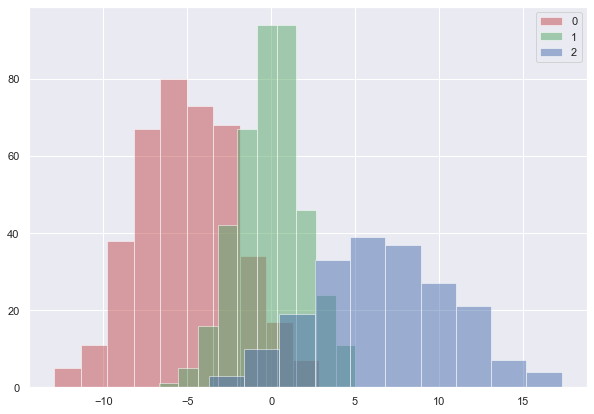

In [36]:
"サンプリングしたデータからヒストグラムを描画"
plt.figure(figsize = (10, 7))
plt.hist(s1, color='r', alpha=0.5, label='0')
plt.hist(s2, color='g', alpha=0.5, label='1')
plt.hist(s3, color='b', alpha=0.5, label='2')
plt.legend()
sns.set()
plt.show()

In [37]:
"各データに対する，各クラスへの所属確率を初期化する関数"
def init_w(N, K):
    arr = np.random.rand(N, K) # 形状が(N,K)の乱数を生成
    norm = np.sum(arr, axis=1) # 1軸で和をとる
    for i in range(len(arr)):
        arr[i] = arr[i] / norm[i] # 1軸の和でわる(各データに対して，各クラスの所属確率の合計を1にするため)
    w0 = arr
    # 後の計算のために転置してからreturn
    return w0.T

In [38]:
"EMアルゴリズムによる学習を行う関数"
def fit(x, N, K, iter=10000):
    # 各データの，各クラスへの所属確率の初期化
    w = init_w(N, K)
    nw = np.empty_like(w)

    # メインのループ
    for loop in range(iter):
        # 各クラスに属するデータ数の推定値を計算
        num = np.sum(w, axis=1)
        # 各クラスの正規分布の平均と分散の推定値を計算
        mu = np.sum(w*x, axis=1) / num
        sig = np.sum(w*(x-mu.reshape(-1,1))**2, axis=1) / num
        sig = np.sqrt(sig)
        # 各クラスの生起確率の推定値を計算
        pi = num / np.sum(num)
        # 各データに対する各クラスの条件付き確率の推定値を計算
        for k in range(K): nw[k] = pi[k] * gauss(mu[k], sig[k], x)
        nw = nw / np.sum(nw, axis=0)
        # w の更新
        w = nw

    print('mu\n{0}\nsig\n{1}\npi\n{2}'.format(mu, sig, pi))
    return mu, sig, pi, w

In [39]:
"実際に学習を行う"
mu_pred, sig_pred, pi_pred, w = fit(x, N, K)

mu
[ 6.78024285 -0.30750459 -5.88530978]
sig
[4.13589415 2.11776916 2.53143296]
pi
[0.19361462 0.49814859 0.30823679]


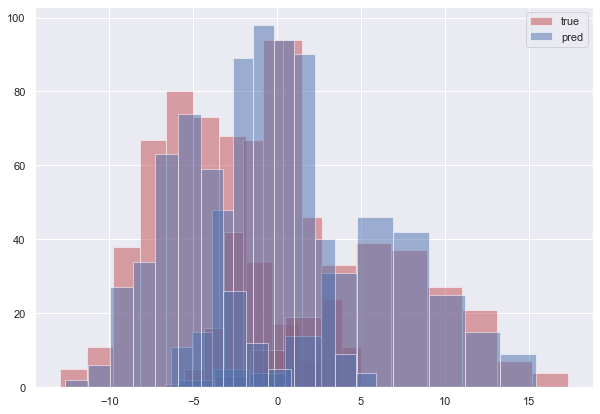

In [40]:
"推定した混合分布と真の混合分布を比較する"
y1_pred = np.random.normal(loc=mu_pred[0], scale=sig_pred[0], size=int(N * pi_pred[0]))
y2_pred = np.random.normal(loc=mu_pred[1], scale=sig_pred[1], size=int(N * pi_pred[1]))
y3_pred = np.random.normal(loc=mu_pred[2], scale=sig_pred[2], size=int(N * pi_pred[2]))
plt.figure(figsize = (10, 7))
# 真の分布
plt.hist(s1, color='r', alpha=0.5)
plt.hist(s2, color='r', alpha=0.5)
plt.hist(s3, color='r', alpha=0.5, label='true')
# 推定した分布
plt.hist(y1_pred, color='b', alpha=0.5)
plt.hist(y2_pred, color='b', alpha=0.5)
plt.hist(y3_pred, color='b', alpha=0.5, label='pred')
plt.legend()
sns.set()
plt.show()

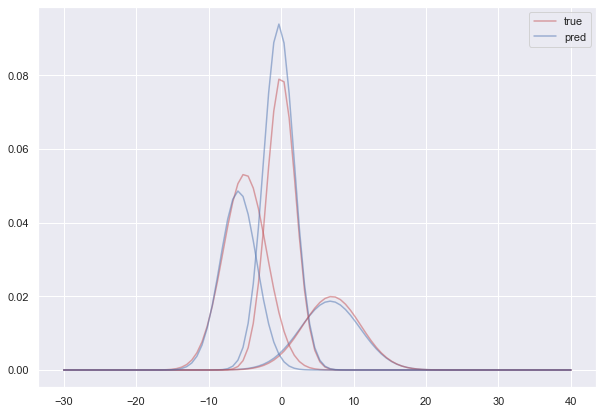

In [41]:
plt.figure(figsize = (10, 7))
u = np.linspace(-30, 40, 100)
for k in range(K):
    pdf_true = pi_true[k] * gauss(mu_true[k], sig_true[k], u)
    pdf_pred = pi_pred[k] *  gauss(mu_pred[k], sig_pred[k], u)
    plt.plot(u, pdf_true, color='r', alpha=0.5)
    plt.plot(u, pdf_pred, color='b', alpha=0.5)
plt.legend(['true', 'pred'])
sns.set()
plt.show()